In [1]:
# !pip install neo4j pandas matplotlib seaborn

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from neo4j import GraphDatabase

# Nastavení stylu grafů pro hezčí vzhled (vhodné do bakalářky)
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 12

In [2]:
class Neo4jAnalytics:
    def __init__(self, uri, user, password):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))

    def close(self):
        self.driver.close()

    def get_df(self, query, params=None):
        """Vykoná dotaz a vrátí výsledek jako Pandas DataFrame"""
        with self.driver.session() as session:
            result = session.run(query, params)
            return pd.DataFrame([r.data() for r in result])

# Připojení (Zkontroluj, zda ti běží Neo4j Desktop!)
db = Neo4jAnalytics("neo4j://127.0.0.1:7687", "neo4j", "heslo123")
print("✅ Připojeno k databázi pro analýzu.")

✅ Připojeno k databázi pro analýzu.


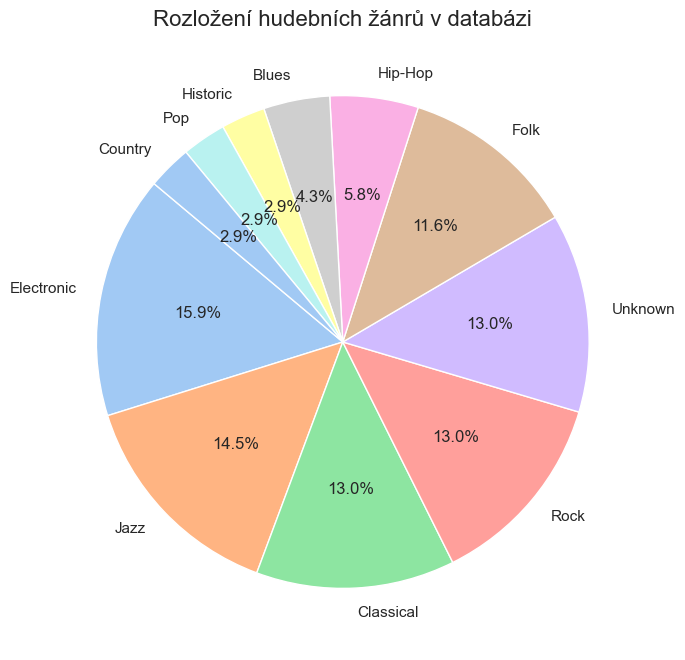

In [3]:
# 1. Získání dat
query_genres = """
MATCH (t:Track)-[:BELONGS_TO]->(g:Genre)
RETURN g.name as Genre, count(t) as Count
ORDER BY Count DESC
"""
df_genres = db.get_df(query_genres)

# 2. Vykreslení koláčového grafu (Pie Chart)
plt.figure(figsize=(8, 8))
plt.pie(df_genres['Count'], labels=df_genres['Genre'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Rozložení hudebních žánrů v databázi', fontsize=16)
plt.show()

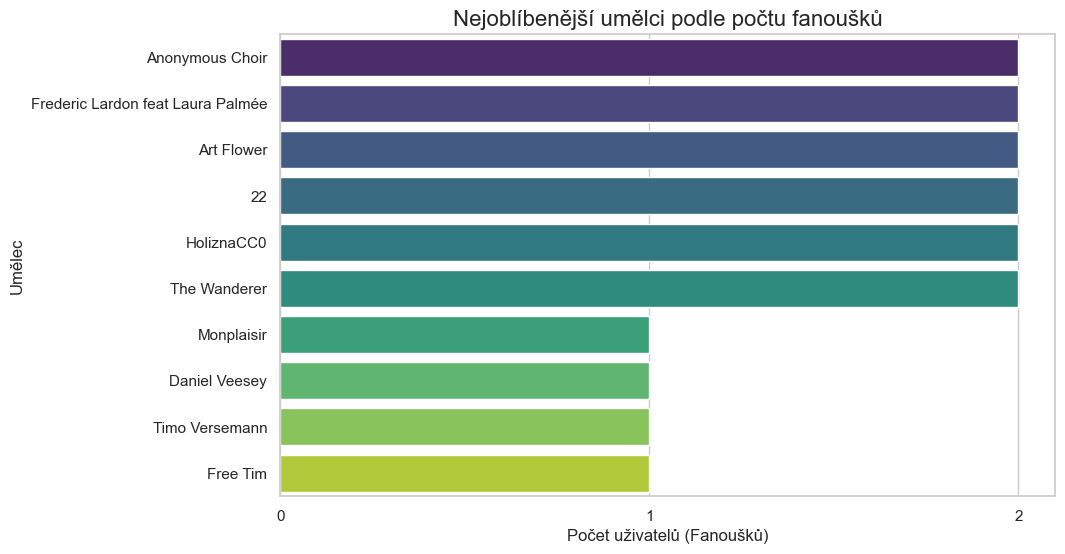

In [4]:
# 1. Získání dat (Počet fanoušků pro každého umělce)
query_artists = """
MATCH (a:Artist)
OPTIONAL MATCH (u:User)-[:IS_A_FAN_OF]->(a)
WITH a, count(u) as Fans
WHERE Fans > 0
RETURN a.name as Artist, Fans
ORDER BY Fans DESC
LIMIT 10
"""
df_artists = db.get_df(query_artists)

# 2. Vykreslení sloupcového grafu (Bar Chart)
plt.figure(figsize=(10, 6))
sns.barplot(x='Fans', y='Artist', hue='Artist', data=df_artists, palette='viridis', legend=False).xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.title('Nejoblíbenější umělci podle počtu fanoušků', fontsize=16)
plt.xlabel('Počet uživatelů (Fanoušků)')
plt.ylabel('Umělec')
plt.show()

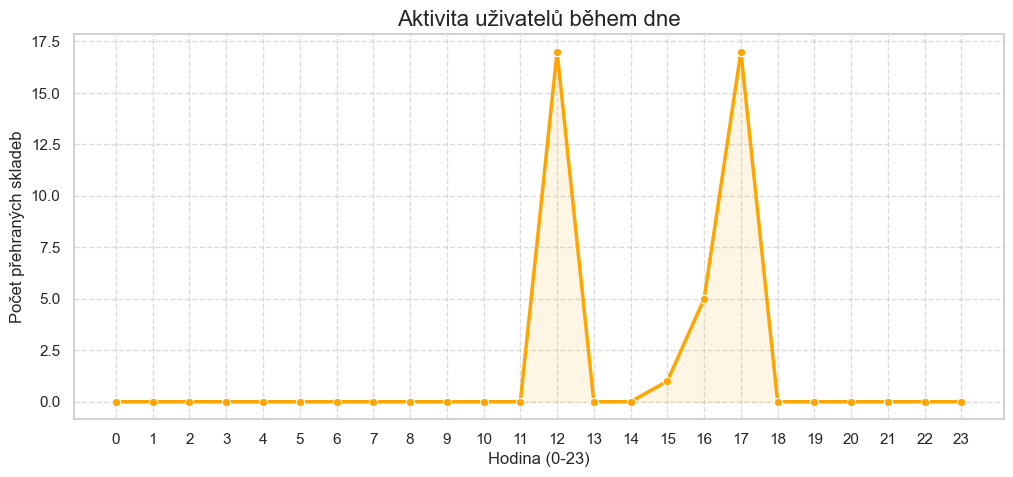

In [5]:
# 1. Získání dat (časy poslechů)
# Předpokládá, že ukládáš 'listenDate' ve formátu ISO string (což děláš v aplikaci)
query_activity = """
MATCH ()-[l:LISTENED_TO]->()
WHERE l.listenDate IS NOT NULL
RETURN l.listenDate as Date
"""
df_activity = db.get_df(query_activity)

if not df_activity.empty:
    # Převod stringu na datetime a extrakce hodiny (0-23)
    df_activity['Hour'] = pd.to_datetime(df_activity['Date']).dt.hour

    # Agregace po hodinách
    hourly_counts = df_activity['Hour'].value_counts().sort_index()

    # Doplnění chybějících hodin (aby osa X měla 0-23)
    for h in range(24):
        if h not in hourly_counts:
            hourly_counts[h] = 0
    hourly_counts = hourly_counts.sort_index()

    # 2. Vykreslení čárového grafu
    plt.figure(figsize=(12, 5))
    sns.lineplot(x=hourly_counts.index, y=hourly_counts.values, marker='o', linewidth=2.5, color='orange')
    plt.title('Aktivita uživatelů během dne', fontsize=16)
    plt.xlabel('Hodina (0-23)')
    plt.ylabel('Počet přehraných skladeb')
    plt.xticks(range(0, 24))
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.fill_between(hourly_counts.index, hourly_counts.values, color='orange', alpha=0.1)
    plt.show()
else:
    print("⚠️ Zatím žádná data o historii poslechu.")